In [ ]:
import torch
import os
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Sabitler
BATCH_SIZE = 32
NUM_EPOCHS = 20

In [ ]:
# Dosya yolları
train_path = "/content/drive/MyDrive/ColabNotebooks/train_data.pt"
test_path = "/content/drive/MyDrive/ColabNotebooks/test_data.pt"

# Yükle
if os.path.exists(train_path) and os.path.exists(test_path):
    train_data, train_labels = torch.load(train_path, weights_only=False)
    test_data, test_labels = torch.load(test_path, weights_only=False)
    print("Veriler başarıyla yüklendi.")
else:
    print("Dosyalar bulunamadı.")

Veriler başarıyla yüklendi.


In [ ]:
class WaveDataset(Dataset):
    # Veriyi alır ve saklar
    def __init__(self, waveforms, labels):
        self.waveforms = waveforms
        self.labels = labels

    # Veri setinin kaç örnek içerdiğini döner
    def __len__(self):
        return len(self.labels)

    # Belirli bir örneği işler ve döner
    def __getitem__(self, idx):
        waveform = self.waveforms[idx]
        label = self.labels[idx]

        # Z-score normalize
        waveform = (waveform - np.mean(waveform)) / (np.std(waveform) + 1e-8)

        # PyTorch tensor
        waveform_tensor = torch.tensor(waveform.T, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32)  # Binary classification

        return waveform_tensor, label_tensor


In [ ]:
# Datasetler
train_dataset = WaveDataset(train_data, train_labels)
test_dataset = WaveDataset(test_data, test_labels)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class PDetectionCNN(nn.Module):
    def __init__(self):
        super(PDetectionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3,  out_channels=16, kernel_size=7, padding=3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32*100, 64)  # window_size=400 için
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

Kullanılan cihaz: cuda


In [ ]:
model = PDetectionCNN().to(device)
criterion = nn.BCELoss()  # binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for waveforms, labels in test_loader:
            waveforms, labels = waveforms.to(device), labels.to(device).unsqueeze(1)
            outputs = model(waveforms)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Accuracy hesaplama
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy




In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    # Training loop with tqdm
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for waveforms, labels in train_pbar:
        waveforms, labels = waveforms.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(waveforms)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Training accuracy
        predicted = (outputs > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Update progress bar
        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100 * train_correct / train_total:.2f}%'
        })

    # Validation
    val_loss, val_acc = evaluate_model(model, test_loader, criterion, device)
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 135.84it/s, Loss=0.3511, Acc=78.19%]


Epoch 1/20 - Train Loss: 0.4498, Train Acc: 78.19%, Val Loss: 0.3629, Val Acc: 85.25%


Epoch 2/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 102.46it/s, Loss=0.1637, Acc=86.77%]


Epoch 2/20 - Train Loss: 0.3092, Train Acc: 86.77%, Val Loss: 0.3007, Val Acc: 87.62%


Epoch 3/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 139.60it/s, Loss=0.2279, Acc=90.27%]


Epoch 3/20 - Train Loss: 0.2274, Train Acc: 90.27%, Val Loss: 0.2928, Val Acc: 87.69%


Epoch 4/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 135.61it/s, Loss=0.1622, Acc=93.67%]


Epoch 4/20 - Train Loss: 0.1590, Train Acc: 93.67%, Val Loss: 0.2617, Val Acc: 89.69%


Epoch 5/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 137.88it/s, Loss=0.0322, Acc=95.75%]


Epoch 5/20 - Train Loss: 0.1094, Train Acc: 95.75%, Val Loss: 0.2444, Val Acc: 90.38%


Epoch 6/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 113.41it/s, Loss=0.0724, Acc=97.34%]


Epoch 6/20 - Train Loss: 0.0778, Train Acc: 97.34%, Val Loss: 0.2607, Val Acc: 90.06%


Epoch 7/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 109.03it/s, Loss=0.0395, Acc=98.55%]


Epoch 7/20 - Train Loss: 0.0521, Train Acc: 98.55%, Val Loss: 0.2946, Val Acc: 90.44%


Epoch 8/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 132.50it/s, Loss=0.0081, Acc=99.25%]


Epoch 8/20 - Train Loss: 0.0279, Train Acc: 99.25%, Val Loss: 0.3025, Val Acc: 90.06%


Epoch 9/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 134.38it/s, Loss=0.0076, Acc=99.89%]


Epoch 9/20 - Train Loss: 0.0130, Train Acc: 99.89%, Val Loss: 0.3529, Val Acc: 90.12%


Epoch 10/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 134.01it/s, Loss=0.0201, Acc=99.95%]


Epoch 10/20 - Train Loss: 0.0070, Train Acc: 99.95%, Val Loss: 0.3629, Val Acc: 90.88%


Epoch 11/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 134.96it/s, Loss=0.0092, Acc=100.00%]


Epoch 11/20 - Train Loss: 0.0047, Train Acc: 100.00%, Val Loss: 0.3851, Val Acc: 90.50%


Epoch 12/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 136.71it/s, Loss=0.0017, Acc=100.00%]


Epoch 12/20 - Train Loss: 0.0037, Train Acc: 100.00%, Val Loss: 0.4478, Val Acc: 90.81%


Epoch 13/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 133.76it/s, Loss=0.0008, Acc=100.00%]


Epoch 13/20 - Train Loss: 0.0020, Train Acc: 100.00%, Val Loss: 0.4771, Val Acc: 90.75%


Epoch 14/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 113.00it/s, Loss=0.0003, Acc=100.00%]


Epoch 14/20 - Train Loss: 0.0009, Train Acc: 100.00%, Val Loss: 0.5009, Val Acc: 90.88%


Epoch 15/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 105.08it/s, Loss=0.0003, Acc=100.00%]


Epoch 15/20 - Train Loss: 0.0006, Train Acc: 100.00%, Val Loss: 0.5116, Val Acc: 90.81%


Epoch 16/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 107.98it/s, Loss=0.0015, Acc=100.00%]


Epoch 16/20 - Train Loss: 0.0005, Train Acc: 100.00%, Val Loss: 0.5199, Val Acc: 90.69%


Epoch 17/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 111.63it/s, Loss=0.0001, Acc=100.00%]


Epoch 17/20 - Train Loss: 0.0004, Train Acc: 100.00%, Val Loss: 0.5279, Val Acc: 90.81%


Epoch 18/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 134.11it/s, Loss=0.0002, Acc=100.00%]


Epoch 18/20 - Train Loss: 0.0003, Train Acc: 100.00%, Val Loss: 0.5383, Val Acc: 90.50%


Epoch 19/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 132.73it/s, Loss=0.0001, Acc=100.00%]


Epoch 19/20 - Train Loss: 0.0003, Train Acc: 100.00%, Val Loss: 0.5482, Val Acc: 90.88%


Epoch 20/20 [Train]: 100%|██████████| 200/200 [00:01<00:00, 132.55it/s, Loss=0.0003, Acc=100.00%]


Epoch 20/20 - Train Loss: 0.0002, Train Acc: 100.00%, Val Loss: 0.5645, Val Acc: 90.25%


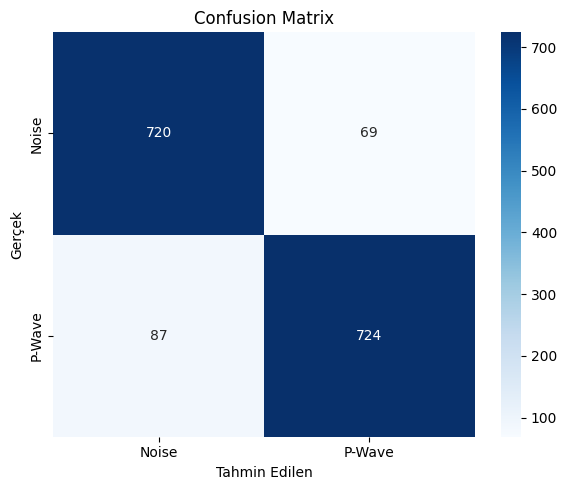

In [ ]:
# --- Confusion Matrix ve Görselleştirme ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for waveforms, labels in test_loader:
        waveforms = waveforms.to(device)
        labels = labels.to(device)
        outputs = model(waveforms)
        predicted = (outputs > 0.5).int().cpu().numpy()
        all_preds.extend(predicted.flatten())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix hesapla
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Noise', 'P-Wave'], yticklabels=['Noise', 'P-Wave'])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Classification Report
print("\nTest Classification Report:")
print(classification_report(all_labels, all_preds))


Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       789
         1.0       0.91      0.89      0.90       811

    accuracy                           0.90      1600
   macro avg       0.90      0.90      0.90      1600
weighted avg       0.90      0.90      0.90      1600

